In [1]:
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from torchvision.models import resnet50
import cv2
import numpy as np
import matplotlib.pyplot as plt
import timm

import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

## Original GradCAM output - reproduced

In [2]:
image_path = "/mnt/dfs/nuislam/Projects/DINO_Detection/pytorch_grad_cam/examples/both.png"

# model = resnet50(pretrained=True)
# target_layers = [model.layer4[-1]]

model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
target_layers = [model.layers[-1].blocks[-1].norm2]
model.eval()

rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
print("rgb_img", rgb_img.max(), rgb_img.min(), rgb_img.shape)
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                std=[0.5, 0.5, 0.5])
print("input_tensor", input_tensor.max(), input_tensor.min(), input_tensor.shape)


# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False, reshape_transform=reshape_transform)
# targets = [ClassifierOutputTarget(281)]
targets = None
grayscale_cam = cam(input_tensor=input_tensor, targets=targets, eigen_smooth=True, aug_smooth=True)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(visualization)

/home/nuislam/miniconda3/envs/tf-detr_gpu/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


rgb_img 1.0 0.0 (224, 224, 3)
input_tensor tensor(1.) tensor(-1.) torch.Size([1, 3, 224, 224])


IndexError: index 2 is out of bounds for dimension 0 with size 1

## Model as the whole Integrated Model

In [2]:
import torch
from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

model_config_path = "config/DINO/DINO_4scale_swinBASE.py"
# model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_vindrcxr_OrganLocSeg_Cyclic6_EMA/#From_SOL/run501_BackboneFreeze_LocSeg_H/ckpt_E20_TH1.pth"
# # model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_vindrcxr_OrganLocSeg_Cyclic6_EMA/#From_SOL/run601_v2_EMA_ContTr_LocSeg_H/ckpt_E434_TH1.pth"
# model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_vindrcxr_OrganDetect_Cyclic/run109LowLR_cyclic_LocMultiHead_L2Reg_LinProj_AllLoss_HLLRL/fromSOL/ckpt_E431_TH7.pth"
# ckpt_E431_TH7 TrRL # ckpt_E398_TH1 TrH   

### NODE21
model_checkpoint_path = "/mnt/dfs/nuislam/Projects/IntegratedModel_GitHubV/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_Node21_Nodule/run103_DFS_LocCls/ckpt_E136_TH2.pth"


args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
args.backbonemodel = "Swin-B"
args.taskcomponent = "detection"
# args.dataset_file = "coco"
# args.dataset_file = "chestxdetdataset"
# args.dataset_file = "vindrcxr_detect"
args.dataset_file = "vindrcxr_OrganDetect"
args.init = None
# args.init = "ark"
args.backbone_dir = "/mnt/dfs/nuislam/Projects/DINO_Detection_old/checkpoints/checkpoint0029_4scale_swin.pth"
# args.backbone_dir = "/mnt/dfs/nuislam/pretrainedModels/Ark6/TSconsist_NoOD_MIMIC_CheXpert_ChestXray14_RSNAPneumonia_VinDrCXR_Shenzhen_ep200.pth.tar"
# args.backbone_dir = None
args.num_classes = 2 # was 91 COCO
args.numClasses = 1
args.dn_labelbook_size = 3

args.lr_backbone = 0.001
model, criterion, postprocessors = build_model_main(args)

checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
# for k,v in checkpoint['model'].items():
#     print(k, v.shape)

# State_CHECK=model.load_state_dict(checkpoint['model'], strict=False)
# State_CHECK = model.load_state_dict(checkpoint['model'], strict=False)

new_state_dict = {}
for key, value in checkpoint['teacher_model'].items():
    new_key = key.replace('module.', '')  # Remove the module. prefix
    new_state_dict[new_key] = value
State_CHECK = model.load_state_dict(new_state_dict, strict=False)

print(State_CHECK)
model = model.to(torch.device("cuda"))
# model = model.cuda()
# model.cpu()
_ = model.eval()

# target_layers = [model.backbone[0].layers[-1].blocks[-1].norm1]

PyTorch random seed: 12958355711931549254
NumPy random seed: None
use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!
<All keys matched successfully>


## Model as only the Backbone (Swin-B)

In [16]:
import torch
import json
model = None
checkpoint = None
grayscale_cam = None

# model = timm.create_model('swin_base_patch4_window7_224', pretrained=False)
model = timm.create_model('swin_base_patch4_window7_224_in22k', pretrained=False)
# print("params:\n"+json.dumps({n: p.numel() for n, p in model.named_parameters() if p.requires_grad}, indent=2))

# model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_vindrcxr_OrganLocSeg_Cyclic6_EMA/#From_SOL/run501_BackboneFreeze_LocSeg_H/ckpt_E20_TH1.pth"
# model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_vindrcxr_OrganLocSeg_Cyclic6_EMA/#From_SOL/run601_v2_EMA_ContTr_LocSeg_H/ckpt_E434_TH1.pth"
# model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_vindrcxr_OrganLocSeg_Cyclic6_EMA/#From_SOL/run601_EMA_ContTr_LocSeg_LL/ckpt_E106_TH3.pth"
model_checkpoint_path = "/mnt/dfs/nuislam/Projects/DINO_Detection/Model_Checkpoints/IntegratedModel_DINOpipeline/Swin-B_224_Ark6_UperNet_FineTune_vindrcxr_OrganDetect_Cyclic/run109LowLR_cyclic_LocMultiHead_L2Reg_LinProj_AllLoss_HLLRL/fromSOL/ckpt_E431_TH7.pth" # 431 TrRL # 398 TrH   

model_checkpoint_path = "/mnt/dfs/nuislam/Projects/BenchmarkVisionTransformer/Models/Classification/node21_SwinTbase_Ark6_Node21_adamw_v1/swin_base_ark6/swin_base_ark6_epoch_33.pth.tar"

print()
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
new_state_dict = {}
for key, value in checkpoint.items():
    if 'backbone' in key and 'segmentation_' not in key:
#         new_key = key.replace('module.backbone.0.', '')  # Remove the module. prefix
        new_key = key.replace('backbone.0.', '')
        if 'head' in key:
            continue
        new_state_dict[new_key] = value
#     print(new_key)
State_CHECK = model.load_state_dict(new_state_dict, strict=False)
print(State_CHECK)

# backbone_dir="/mnt/dfs/nuislam/pretrainedModels/Ark6/TSconsist_NoOD_MIMIC_CheXpert_ChestXray14_RSNAPneumonia_VinDrCXR_Shenzhen_ep200.pth.tar"
# checkpoint = torch.load(backbone_dir, map_location='cpu')
# new_state_dict = {}
# for key, value in checkpoint['teacher'].items():
#     if 'head' in key:
#         continue
#     new_key = key.replace('module.', '')  # Remove the module. prefix
#     new_state_dict[new_key] = value
# State_CHECK = model.load_state_dict(new_state_dict, strict=False)
# print(State_CHECK)


target_layers = [model.layers[-1].blocks[-1].norm2]
# target_layers = [model.layers[-1].blocks[-1].norm1]
model.eval()


_IncompatibleKeys(missing_keys=['patch_embed.proj.weight', 'patch_embed.proj.bias', 'patch_embed.norm.weight', 'patch_embed.norm.bias', 'layers.0.blocks.0.norm1.weight', 'layers.0.blocks.0.norm1.bias', 'layers.0.blocks.0.attn.relative_position_bias_table', 'layers.0.blocks.0.attn.relative_position_index', 'layers.0.blocks.0.attn.qkv.weight', 'layers.0.blocks.0.attn.qkv.bias', 'layers.0.blocks.0.attn.proj.weight', 'layers.0.blocks.0.attn.proj.bias', 'layers.0.blocks.0.norm2.weight', 'layers.0.blocks.0.norm2.bias', 'layers.0.blocks.0.mlp.fc1.weight', 'layers.0.blocks.0.mlp.fc1.bias', 'layers.0.blocks.0.mlp.fc2.weight', 'layers.0.blocks.0.mlp.fc2.bias', 'layers.0.blocks.1.attn_mask', 'layers.0.blocks.1.norm1.weight', 'layers.0.blocks.1.norm1.bias', 'layers.0.blocks.1.attn.relative_position_bias_table', 'layers.0.blocks.1.attn.relative_position_index', 'layers.0.blocks.1.attn.qkv.weight', 'layers.0.blocks.1.attn.qkv.bias', 'layers.0.blocks.1.attn.proj.weight', 'layers.0.blocks.1.attn.proj

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      dim=128, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
     

## Input for the Model to get GradCam Viz

rgb_img 0.99215686 0.0 (224, 224, 3)
input_tensor tensor(0.9843, device='cuda:0') tensor(-1., device='cuda:0') torch.Size([1, 3, 224, 224])


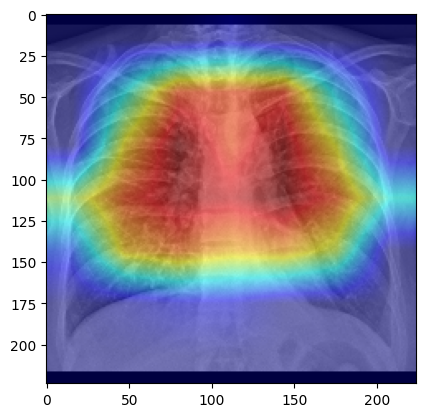

In [14]:
def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# def reshape_transform(tensor, height=16, width=16):
#     print("Check: result A:", tensor.shape)
#     result = tensor.view(1, 1045, 16, 16) ## For model.transformer.encoder outputs
# #     result = tensor.view(1, 30, 30, 256) ## For model.decoder outputs ## doesn't work
#     print("Check: result B:", result.shape)
#     return result

# VinDr-CXR ORGAN
# image_path = "/mnt/dfs/jpang12/datasets/VinDr-CXR/physionet.org/files/vindr-cxr/1.0.0/test_jpeg/"
# # e0dc2e79105ad93532484e956ef8a71a
# # 0aed23e64ebdea798486056b4f174424
# # aa15cfcfca7605465ca0513902738b95
# # 00a2145de1886cb9eb88869c85d74080
# # 0a1addecfc432a1b425d61fe57bc29d2
# # 5c55f871429730b84a8ee275839b8aae
# # bf754344a692a87c08c480dccf75e0c6
# # 31b4de538dd6272b05e295142c5ccc2a
# # 9262bfe5dc41410f1725ebdd26a22334
# # 4dcaf539b6497ad02f2734e1b78c9678
# image_path = image_path + "e0dc2e79105ad93532484e956ef8a71a" + ".jpeg"

## NODE21
image_path = "/mnt/dfs/nuislam/Data/NODE21_ann/images_png/"
image_path = image_path + "n0977" + ".png"

rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
print("rgb_img", rgb_img.max(), rgb_img.min(), rgb_img.shape)
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                std=[0.5, 0.5, 0.5])

input_tensor = input_tensor.to(torch.device("cuda"))
print("input_tensor", input_tensor.max(), input_tensor.min(), input_tensor.shape)
# rgb_img = rgb_img.cuda()
# input_tensor = input_tensor.cuda()
# input_tensor = input_tensor[:]

# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
methods = \
    {"gradcam": GradCAM,
     "scorecam": ScoreCAM,
     "gradcam++": GradCAMPlusPlus,
     "ablationcam": AblationCAM,
     "xgradcam": XGradCAM,
     "eigencam": EigenCAM,
     "eigengradcam": EigenGradCAM,
     "layercam": LayerCAM,
     "fullgrad": FullGrad}

model.task_DetHead = 1
## For the Integrated Model ## model.backbone[0].layers[-1].blocks[-1].norm1 || model.transformer.decoder[2].layers[5].norm3 ||  model.transformer.encoder.layers[5].norm2
target_layers = [model.backbone[0].layers[-1].blocks[-1].norm1, model.backbone[0].layers[-1].blocks[-1].norm2] ## For the Integrated Model
# target_layers = [model.transformer.encoder.layers[5].norm1, model.transformer.encoder.layers[5].norm2]
# target_layers = [model.transformer.decoder[2].layers[5].linear2]

# cam = methods['gradcam++'](model=model, target_layers=target_layers, use_cuda=True, reshape_transform=reshape_transform) ## eigencam good for Organ Localization
cam = methods['gradcam'](model=model, target_layers=target_layers, use_cuda=True, reshape_transform=reshape_transform) ## Organ gradcam
# targets = [ClassifierOutputTarget(281)]
targets = None
grayscale_cam = cam(input_tensor=input_tensor, targets=targets, eigen_smooth=True, aug_smooth=True) ## Organ True True
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(visualization)


## NOTE: What's Working
# Target Layer = average of backbone's last norm1 and norm2 [model.backbone[0].layers[-1].blocks[-1].norm1, model.backbone[0].layers[-1].blocks[-1].norm2]
# Eigen and Aug smooth = True
# gradcam, gradcam++ & eigencam

In [3]:
print(timm.__version__)

0.5.4
